# von Neumann analysis

A von Neumann analysis is one of the easier ways to draw quantitative conclusions about stability and accuracy. Here we look at 

$$
\partial_t u + c \partial_x u = 0
$$

on the entire real line. We suppose a uniform grid in space with spacing $h$. The semidiscrete approach is to use 

$$
u(x,t) = v(t) e^{i\xi x}, \quad v(0)=1,
$$

with $\xi \in [-\pi/h,\pi/h)$ due to aliasing on the grid. 

For numerical simulations, we can choose to use periodic conditions in order to keep the domain finite. (We will see later that this has the effect of additionally discretizing the wavenumber $\xi$.) This gives ODEs in the form $\partial_t \mathbf{u} = -c\mathbf{A} \mathbf{u}$, where $\bfA$ is a differentiation matrix.

## Centered in space

For 2nd-order differences in space, we get

$$
v'(t) &= -c \frac{e^{i\xi h}-e^{-i\xi h}}{2h} v(t)\\ 
 &= -\frac{ic}{h} v(t) \sin(\xi h)\\ 
 & = \lambda(\xi) v(t).
$$

As $\xi$ varies over $[-\pi/h,\pi/h)$, $\lambda(\xi)$ varies along the imaginary axis between $\pm ic/h$. 

This linear ODE shows that stability analysis of a fully discrete realization is identical to checking that $\tau \lambda(\xi)$ lies within the stability region of the method used to discretize time. Let's work through the details in some cases. 

### Euler

Euler discretization in time leads to $v_{j+1} = v_j + \tau \lambda v_j$. That is, the solution is (of course) exponential: $v_j = g^j$ for all $j$, where 

$$
g(\xi) = 1 + \tau \lambda(\xi).
$$

Here, $g$ is known as the **amplification factor** of the method. 

Since $\lambda$ is purely imaginary, we have $|g| > 1$ except when $\lambda=0$. Furthermore, $|g|$ is maximized when $|\lambda|$ is maximized, which happens when $|\sin(\xi h)|=1$, or $\xi h = \pm \pi/2$. This is the mode that will blow up most rapidly.

In [1]:
include("diffmats.jl")
using OrdinaryDiffEq

n = 100
c = -1
u₀ = x -> exp(2*sin(2π*x))

x,Dx,_ = diffmats(n,0,1,periodic=true)
advect(u,c,t) = -c*(Dx*u)

ivp = ODEProblem(advect,u₀.(x),(0.,10.),c)
sol = solve(ivp,Euler(),dt=1/1000);

In [2]:
using Plots,PyFormattedStrings
anim = @animate for t in range(0,8,201)
    plot(x,sol(t),label=f"t={t:.1f}",m=2,
        xaxis=("x"),yaxis=("u(x,t)",[-3,9]),dpi=140)
end
mp4(anim,"advect1.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/advection/advect1.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/CUQan/src/animation.jl:139


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/advection/advect1.mp4")

Note the onset of an exponential instability takes a while. Here is a snapshot shortly after it becomes obvious:

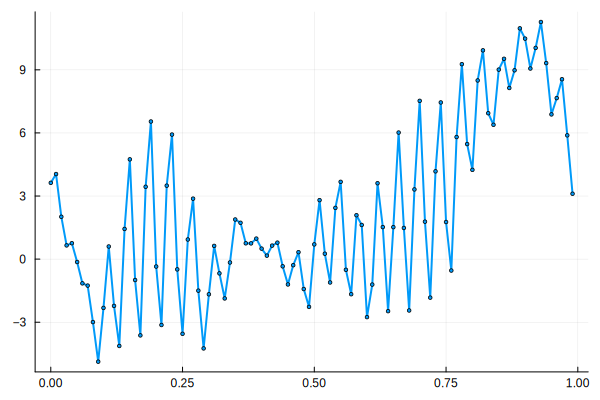

In [3]:
plot(x,sol(7.4),m=2)

The pattern here has oscillations with just one grid point in-between successive extremes. This is like $-1,0,1,0,-1,0,\ldots$, as opposed to the sawtooth $-1,1,-1,1,\ldots$, so we are at half the max wavenumber, or $\xi = \pi/2h$. 

We are pretty much recovering old ground here. The eigenvalues of the differentiation matrix are imaginary and discretize the interval $[=ic/h,ic/h]$:

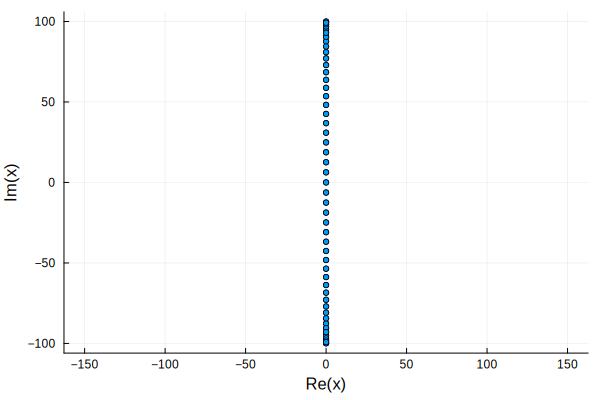

In [4]:
scatter(eigvals(-c*Matrix(Dx)),m=3,label="",aspect_ratio=1)

No matter how these are scaled by $\tau$, they will never fit inside Euler's stability region. 

### Trapezoid

Suppose instead we use the trapezoid formula AM2 with our centered difference in space. Then we get $g = 1 + \tfrac{1}{2}\tau (1+g) \lambda$, or 

$$
g(\xi) = \frac{2+\tau\lambda}{2-\tau\lambda}. 
$$

The fact that $\lambda$ is imaginary now implies $|g|=1$ at all wavenumbers. This is ideal from the perspective that the exact solutions of the problem do not decay or grow. Again, we saw this fact earlier in that the imaginary axis lies on the boundary of the stability region, perfectly balanced between decay and growth.

In [5]:
sol = solve(ivp,Trapezoid(),dt=1/20,adaptive=false);
anim = @animate for t in range(0,8,201)
    plot(x,sol(t),label=f"t={t:.1f}",m=2,
        xaxis=("x"),yaxis=("u(x,t)",[-3,9]),dpi=140)
end
mp4(anim,"advect2.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/advection/advect2.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/CUQan/src/animation.jl:139


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/advection/advect2.mp4")

In the demo above, a rather ridiculously large time step was used to prove two points: that the stability is unconditional, and that stability doesn't mean that the solution is *good* in the sense of pointwise accuracy.

It's worth mentioning that the neutral stability here can cut two ways. It's nice to have what amounts to conservation of energy in your method, when the exact solution has the same property. However, this characteristic tends to be fragile and may devolve to instability in the presence of changes like variable wave speed or nonlinearity.

## Upwind in space

Sticking with $c=-1$, the upwind direction implies a forward difference. This leads to

$$
v'(t) &= -c \frac{e^{i\xi h}-1}{h} v(t)\\ 
 & = \lambda(\xi) v(t).
$$

In the complex plane, $e^{i\xi h}$ covers the unit circle as $\xi h$ ranges over $[-\pi,\pi)$. This circle is shifted to have center at $z=-1$ and then scaled by $-c/h$ to get $\lambda$. This result implies that content at all wavenumbers except $\xi=0$ is damped in time. The damping is baked into the upwind spatial discretization, independently of how the time integration is carried out.

If we use Euler in time, then absolute stability will follow if $2c\tau /h \ge -2$, or $\tau \le h/|c|$.

In [6]:
h = 1/n
Dx = (1/h)*spdiagm(0=>-ones(n),1=>ones(n-1),1-n=>[1.])
sol1 = solve(ivp,Euler(),dt=h/abs(c)*0.95,adaptive=false)
sol2 = solve(ivp,Euler(),dt=h/abs(c)*1.05,adaptive=false)

anim = @animate for t in range(0,5,201)
    plot(x,sol1(t),label="stable",
        xaxis=("x"),yaxis=("u(x,t)",[-3,9]),dpi=140)
    plot!(x,sol2(t),label="unstable",m=2)
end
mp4(anim,"advect3.mp4")

┌ Info: Saved animation to 
│   fn = /Users/driscoll/Dropbox/class/817/notes/advection/advect3.mp4
└ @ Plots /Users/driscoll/.julia/packages/Plots/CUQan/src/animation.jl:139


Plots.AnimatedGif("/Users/driscoll/Dropbox/class/817/notes/advection/advect3.mp4")

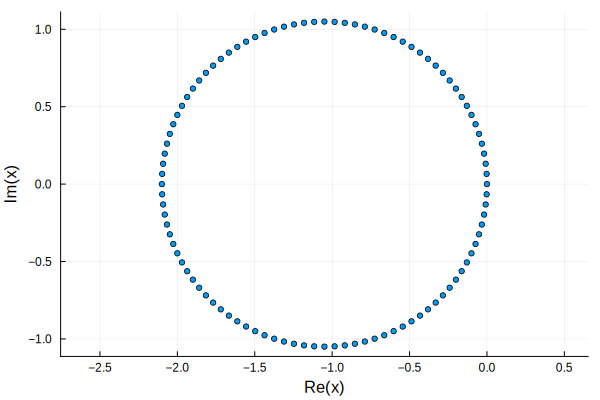

In [7]:
scatter(eigvals(-c*1.05h*Matrix(Dx)),m=3,label="",aspect_ratio=1)

By contrast, both trapezoid and backward Euler are unconditionally stable.